# Sequence Processing

Source:

* https://www.kaggle.com/tartakovsky/pytorch-lightning-lstm-timeseries-clean-code
* https://keras.io/examples/timeseries/timeseries_weather_forecasting/

We will be using Jena Climate dataset recorded by the Max Planck Institute for Biogeochemistry. The dataset consists of 14 features such as temperature, pressure, humidity etc, recorded once per 10 minutes.

Location: Weather Station, Max Planck Institute for Biogeochemistry in Jena, Germany

Time-frame Considered: Jan 10, 2009 - December 31, 2016

# Imports

In [2]:
! pip install pytorch-lightning

     |████████████████████████████████| 523 kB 4.2 MB/s 
     |████████████████████████████████| 829 kB 34.9 MB/s 
     |████████████████████████████████| 596 kB 45.1 MB/s 
     |████████████████████████████████| 329 kB 44.5 MB/s 
     |████████████████████████████████| 132 kB 51.2 MB/s 
     |████████████████████████████████| 1.1 MB 35.2 MB/s 
     |████████████████████████████████| 160 kB 46.5 MB/s 
     |████████████████████████████████| 192 kB 49.8 MB/s 
     |████████████████████████████████| 271 kB 53.2 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=4eb314d9f4e47fe1c1bca2f877a15e2a03fc2353b511c429f6aec3ff04d36ab2
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

In [3]:
# Re-loads all imports every time the cell is ran. 
%load_ext autoreload
%autoreload 2

from time import time

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.5f}'.format
from IPython.display import display

# Sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Neural Networks
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('bmh')
mpl.rcParams['figure.figsize'] = 18, 8

# Data


### Load

In [4]:
! wget -nc "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"

--2021-11-26 13:18:31--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 64.233.189.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  --.-KB/s    in 0.1s    

2021-11-26 13:18:31 (130 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]



In [5]:
from zipfile import ZipFile
zip_file = ZipFile("jena_climate_2009_2016.csv.zip")
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

data = pd.read_csv(csv_path)
data = data.iloc[::200] # only each 200th point

data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52000,-8.02000,265.40000,-8.90000,93.30000,3.33000,3.11000,0.22000,1.94000,3.12000,"1,307.75000",1.03000,1.75000,152.30000
200,02.01.2009 09:30:00,998.53000,-3.90000,269.38000,-4.84000,93.10000,4.57000,4.26000,0.32000,2.66000,4.27000,"1,289.77000",1.42000,1.88000,180.80000
400,03.01.2009 18:50:00,995.37000,-3.87000,269.65000,-10.69000,58.83000,4.59000,2.70000,1.89000,1.69000,2.71000,"1,286.30000",1.73000,2.38000,243.60000
600,05.01.2009 04:10:00,985.44000,-1.77000,272.53000,-3.22000,89.70000,5.36000,4.81000,0.55000,3.04000,4.88000,"1,262.57000",3.11000,5.63000,260.90000
800,06.01.2009 13:30:00,996.63000,-11.09000,262.32000,-15.74000,68.25000,2.61000,1.78000,0.83000,1.11000,1.79000,"1,323.90000",1.10000,2.00000,19.56000


In [6]:
date_time_key = "Date Time"
data[date_time_key] = pd.to_datetime(data[date_time_key], infer_datetime_format=True)
data.set_index(date_time_key, inplace=True)
data.sort_index(inplace=True)
data.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52000,-8.02000,265.40000,-8.90000,93.30000,3.33000,3.11000,0.22000,1.94000,3.12000,"1,307.75000",1.03000,1.75000,152.30000
2009-01-02 22:50:00,982.91000,-2.63000,271.87000,-4.54000,86.60000,5.03000,4.36000,0.67000,2.76000,4.43000,"1,263.55000",4.10000,5.88000,46.33000
2009-01-03 17:30:00,983.27000,8.03000,282.55000,3.62000,73.60000,10.76000,7.92000,2.84000,5.03000,8.05000,"1,214.44000",2.22000,3.88000,181.90000
2009-01-04 06:50:00,994.16000,0.04000,273.65000,-1.43000,89.80000,6.12000,5.50000,0.62000,3.45000,5.53000,"1,265.03000",0.42000,0.75000,182.40000
2009-01-05 20:10:00,994.98000,14.02000,287.59000,10.56000,79.60000,16.03000,12.76000,3.27000,8.02000,12.82000,"1,201.09000",0.97000,2.25000,254.30000


In [7]:
data.shape

(2103, 14)

### Visualization

Let's see what data we got as a result, and also make visualizations.

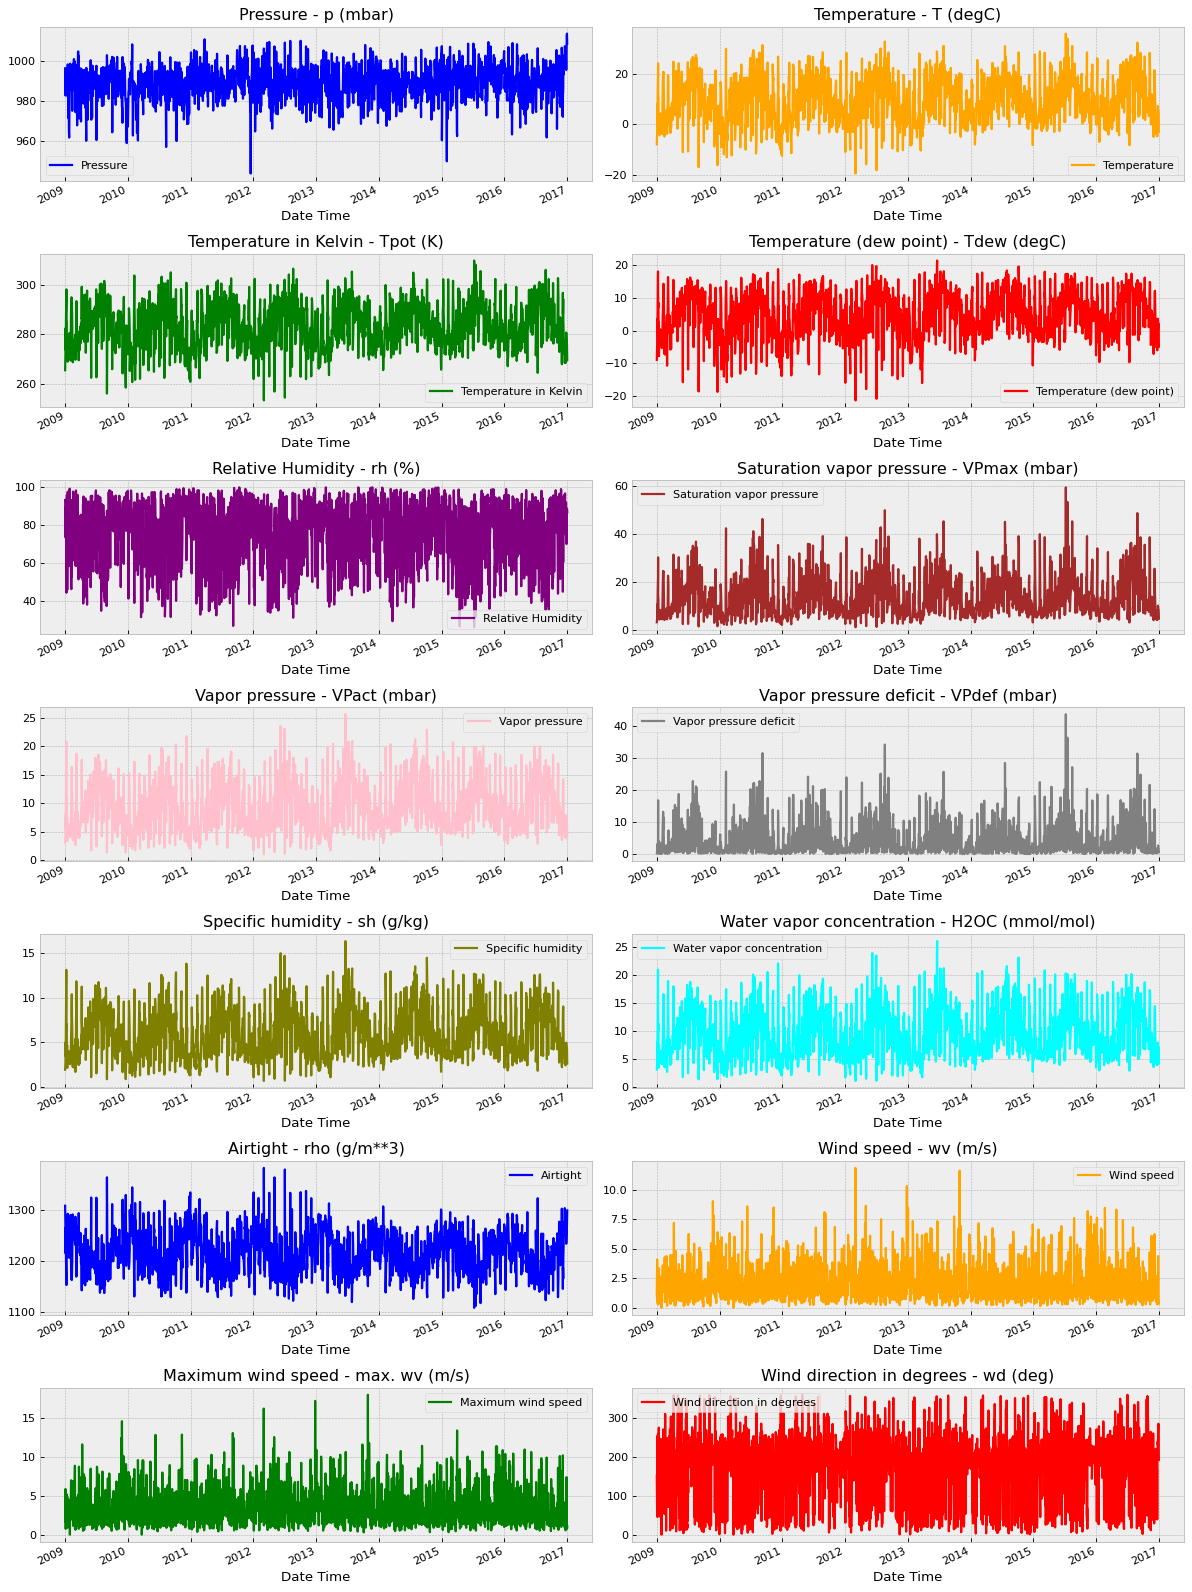

In [8]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]



def show_raw_visualization(data):
    time_data = data.index
    fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k")
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(ax=axes[i // 2, i % 2], color=c, title="{} - {}".format(titles[i], key), rot=25,)
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(data)

### Choose data

Further experiments will be carried out with a Celsius temperature.

In [9]:
data_name = "T (degC)"

# Time Series: play with data

Let's take a look at how data can be decomposed into components:

- **Trend**: The increasing or decreasing value in the series;
- **Seasonality**: The repeating relatively short-term cycle in the series;
- **Noise**: The random deviations in the series.

And also draw the [autocorrelation graph](https://otexts.com/fpp2/non-seasonal-arima.html#acf-and-pacf-plots).

### Trend and seasonality

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


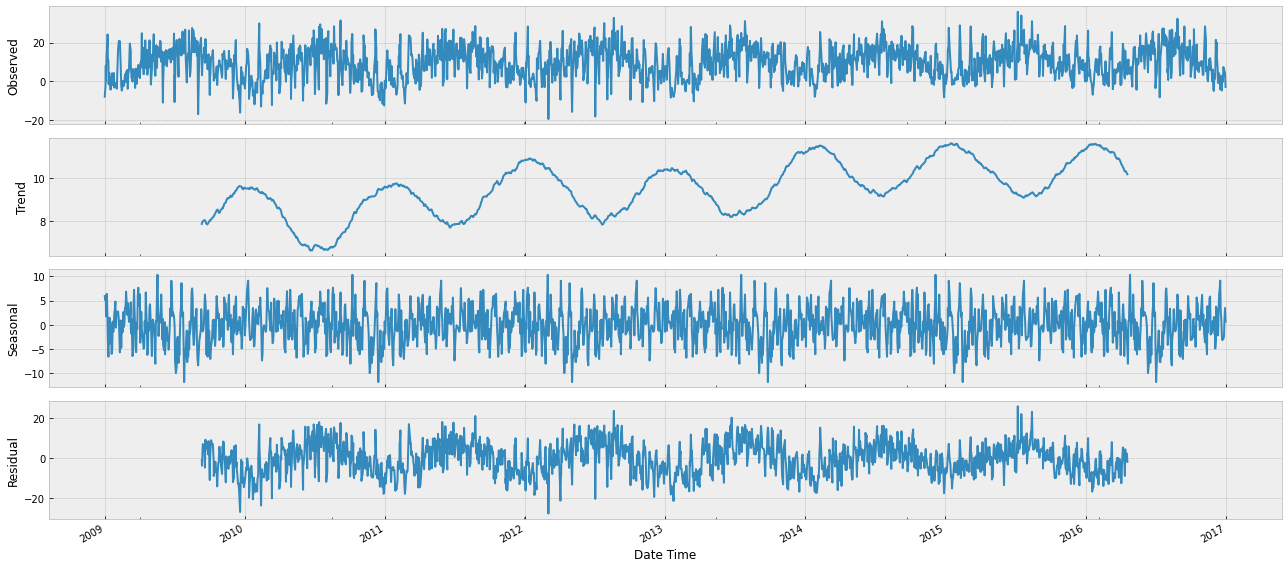

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data[data_name], model='additive', freq=365)
decomposition.plot()
plt.show()

### Autocorrelation

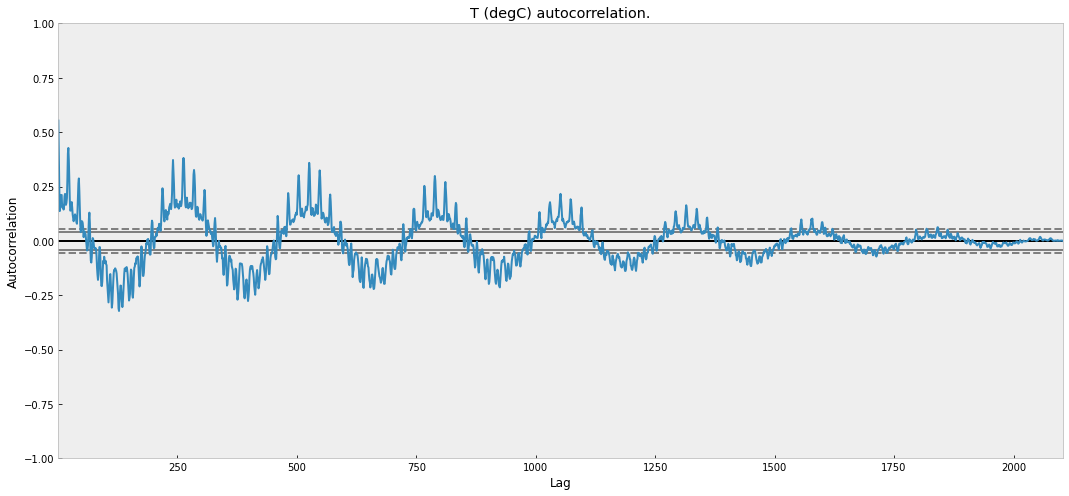

In [11]:
from pandas.plotting import lag_plot

import pandas as pd
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(data[data_name])
plt.title(f'{data_name} autocorrelation.')
plt.show()

In [12]:
print('autocorrelation coef:', data[data_name].autocorr())

autocorrelation coef: 0.5539874019535969


# Task 1

Plot the correlation of $y_{t}$ with $y_ {t+1}$ and calculate the correlation coefficient (see an example in the lecture). What conclusions can we draw from the results obtained?

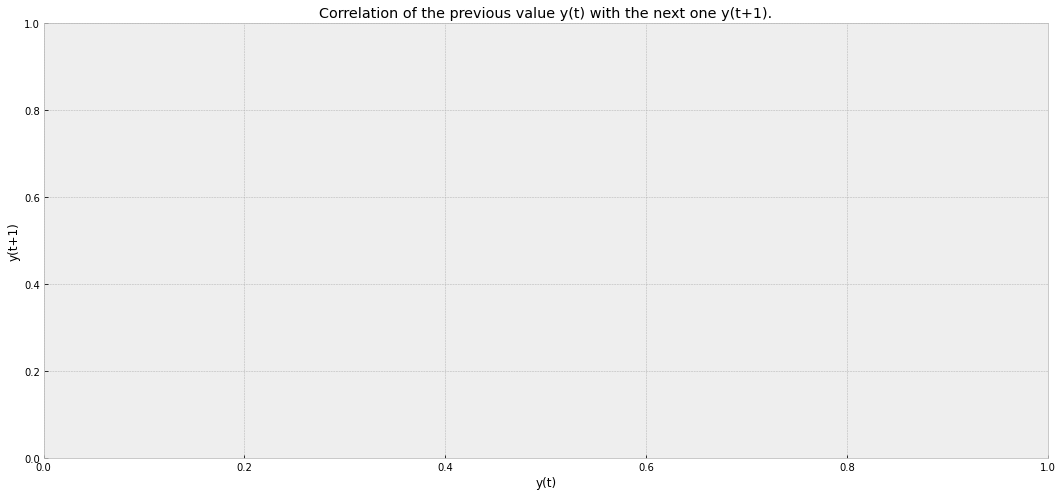

In [13]:
y_curr = data[data_name]# your code where
y_next = np.concatenate([np.array([0]), y_curr[1:]])
# y_next = y_next.fillna(0)# your code where

# your code where (scatter plot)

plt.title('Correlation of the previous value y(t) with the next one y(t+1).')
plt.xlabel('y(t)')
plt.ylabel('y(t+1)')
plt.show()

In [18]:
corrcoef = np.corrcoef(y_curr, y_next)# your code where
print('Correlation coefficient:', corrcoef)

Correlation coefficient: [[1.       0.999783]
 [0.999783 1.      ]]


Conclusion: we see a rather strong positive correlation of the previous step with the next one.

# AR model for time series forecast


Consider $y_1, y_2, ..., y_i, ..., y_N$ are observations of a time series. Autoregressive Model for the time series forecast assumes the following:

$$ \hat{y}_{i+m} = f( y_{i}, y_{i-1}, ... y_{i-k+1} ) $$

where $\hat{y}_{i+m}$ is a predicted value.

In matrix forms we will define this model as:

$$\hat{Y} = f(X)$$

where
$$X = \left(
\begin{array}{cccc}
y_{k} & y_{k-1} & \ldots & y_{1}\\
\vdots & \vdots & \ddots & \vdots\\
y_{k+j} & y_{k+j-1} & \ldots & y_{j+1}\\
\vdots & \vdots & \ddots & \vdots
\end{array}
\right)$$

$$Y = \left(
\begin{array}{c}
y_{k+m} \\
\vdots\\
y_{k+j+m}\\
\vdots
\end{array}
\right)$$

### Preprocessing

In [14]:
X = data[[data_name]].values

ss = StandardScaler()
X = ss.fit_transform(X)

Text(0.5, 1.0, 'Preprocessed "T (degC)" data.')

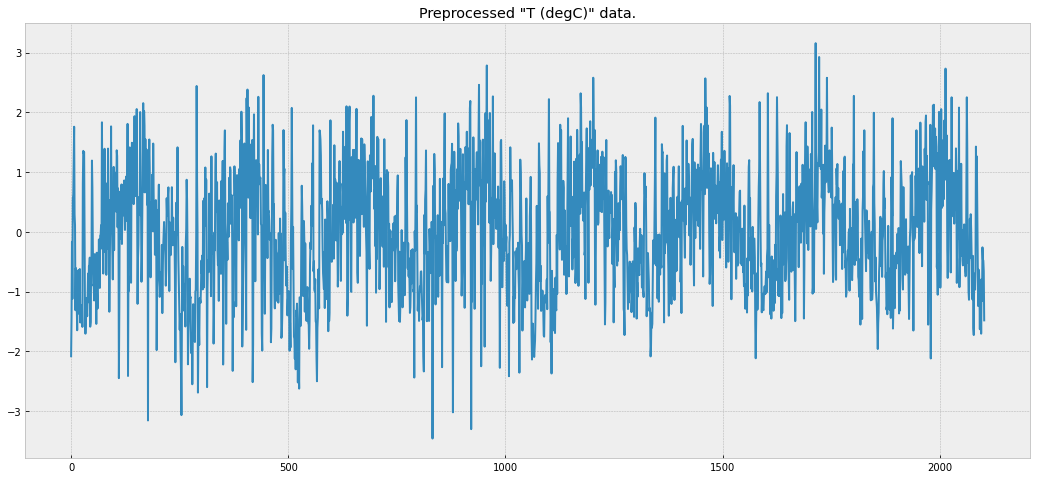

In [15]:
plt.plot(X)
plt.title(f'Preprocessed "{data_name}" data.')

In [16]:
def AR_matrices(Y, k, m):
    X_AR = []
    Y_AR = []
    for i in range(len(Y)):
        
        if i < k-1: continue
        if i+m >= len(Y): break
        
        ax_ar = Y[i+1-k:i+1].reshape(-1, )
        X_AR.append(ax_ar)

        ay_ar = Y[i+m]#[0]
        Y_AR.append(ay_ar)

    return np.array(X_AR), np.array(Y_AR)

In [17]:
# prepare X and Y matrices
k = 1
X_AR, Y_AR = AR_matrices(X, k=k, m=1)
print('X shape:', X.shape)
print('X_AR shape: ', X_AR.shape)
print('Y_AR shape: ', Y_AR.shape)

X shape: (2103, 1)
X_AR shape:  (2102, 1)
Y_AR shape:  (2102, 1)


### Train / test split

In [18]:
N = len(X)//2

X_AR_train, X_AR_test = X_AR[:N], X_AR[N:]
Y_AR_train, Y_AR_test = Y_AR[:N], Y_AR[N:]

### Model

In [19]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X_AR_train, Y_AR_train)

### Prediction

In [20]:
Y_pred_test = model.predict(X_AR_test)

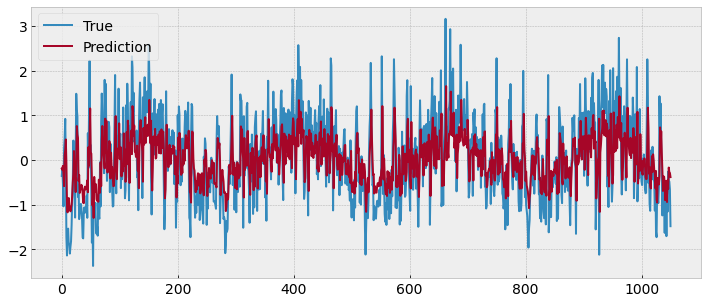

In [21]:
plt.figure(figsize=(12, 5))
plt.plot(Y_AR_test, label='True', alpha=1.)
plt.plot(Y_pred_test, label='Prediction', alpha=1.)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error as mse
print('MSE loss:', mse(Y_AR_test, Y_pred_test))

MSE loss: 0.6207792559153185


# Task 2

Do the same experiment for large k value -- take $k=30$:

* make new datasets;
* train new model;
* compare graphs and MSE losses.

Make sure AR model performs better at higher k values.

In [23]:
new_k = 30

# prepare X and Y matrices
X_AR_new_k, Y_AR_new_k = AR_matrices(X, k=new_k, m=1)

assert X_AR_new_k.shape == (2073, 30)
assert Y_AR_new_k.shape == (2073, 1)

print('X shape:', X.shape)
print('X_AR shape: ', X_AR_new_k.shape)
print('Y_AR shape: ', Y_AR_new_k.shape)

X_AR_train_new_k, X_AR_test_new_k = X_AR_new_k[:N], X_AR_new_k[N:]
Y_AR_train_new_k, Y_AR_test_new_k = Y_AR_new_k[:N], Y_AR_new_k[N:]

assert X_AR_train_new_k.shape == (1051, 30)
assert X_AR_test_new_k.shape == (1022, 30)
assert Y_AR_train_new_k.shape == (1051, 1)
assert Y_AR_test_new_k.shape == (1022, 1)

X shape: (2103, 1)
X_AR shape:  (2073, 30)
Y_AR shape:  (2073, 1)


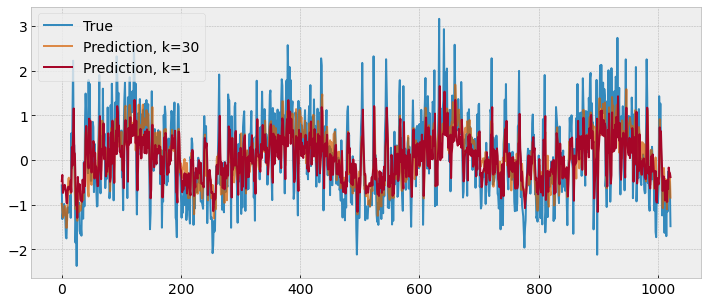

In [24]:
model = LinearRegression().fit(X_AR_train_new_k, Y_AR_train_new_k)

Y_pred_test_new_k = model.predict(X_AR_test_new_k)

assert Y_pred_test_new_k.shape == (1022, 1)

for i in range(Y_AR_test.shape[1]):
    plt.figure(figsize=(12, 5))
    plt.plot(Y_AR_test_new_k[:, i], label='True', alpha=1.)
    plt.plot(Y_pred_test_new_k[:, i], label=f'Prediction, k={new_k}', alpha=.7, color='C4')
    plt.plot(Y_pred_test[-Y_AR_test_new_k.shape[0]:], label='Prediction, k=1', alpha=1.)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', fontsize=14)
    plt.grid(b=1)
    plt.show()

In [25]:
print('MSE loss k=1:', mse(Y_AR_test[-Y_AR_test_new_k.shape[0]:], Y_pred_test[-Y_AR_test_new_k.shape[0]:]))
print(f'MSE loss k={new_k}:', mse(Y_AR_test_new_k, Y_pred_test_new_k))

MSE loss k=1: 0.6189890699940036
MSE loss k=30: 0.5574881091366363


# LSTM model for time series forecast

Now we use a recurrent neural network to solve the problem (note that for such a simple dataset as it is now, it will most likely be more efficient to use a simple model - linear or polynomial).

### Dataset

In [26]:
class TimeseriesDataset(Dataset):   
    '''
    Custom Dataset subclass. 
    Serves as input to DataLoader to transform X 
      into sequence data using rolling window. 
    DataLoader using this dataset will output batches 
      of `(batch_size, seq_len, n_features)` shape.
    Suitable as an input to RNNs. 
    '''
    def __init__(self, X: np.ndarray, y: np.ndarray, seq_len: int = 1):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])

In [27]:
class DataModule(pl.LightningDataModule):
    '''
    LightningDataModule:
    https://pytorch-lightning.readthedocs.io/en/latest/extensions/datamodules.html
    '''
    def __init__(self, seq_len = 1, batch_size = 128, num_workers=0):
        super().__init__()
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.X_test = None
        self.columns = None
        self.preprocessing = None

    def prepare_data(self):
        pass

    def setup(
        self,
        stage=None, 
        X_train=X_AR_train,
        y_train=Y_AR_train,
        X_test=X_AR_test,
        y_test=Y_AR_test,
    ):
        # Assign train/test datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            self.X_train = X_train
            self.y_train = y_train.reshape((-1, 1))
            self.X_val = X_test
            self.y_val = y_test.reshape((-1, 1))
        if stage == 'test' or stage is None:
            self.X_test = X_test
            self.y_test = y_test.reshape((-1, 1))

    def train_dataloader(self):
        train_dataset = TimeseriesDataset(self.X_train, 
                                          self.y_train, 
                                          seq_len=self.seq_len)
        train_loader = DataLoader(train_dataset, 
                                  batch_size = self.batch_size, 
                                  shuffle = False, 
                                  num_workers = self.num_workers)
        
        return train_loader
    
    def val_dataloader(self):
        val_dataset = TimeseriesDataset(self.X_val, 
                                        self.y_val, 
                                        seq_len=self.seq_len)
        val_loader = DataLoader(val_dataset, 
                                batch_size = self.batch_size, 
                                shuffle = False, 
                                num_workers = self.num_workers)

        return val_loader

    def test_dataloader(self):
        test_dataset = TimeseriesDataset(self.X_test, 
                                         self.y_test, 
                                         seq_len=self.seq_len)
        test_loader = DataLoader(test_dataset, 
                                 batch_size = self.batch_size, 
                                 shuffle = False, 
                                 num_workers = self.num_workers)

        return test_loader

### LSTM model

Our model will consist of several LSTM-layers.

In [28]:
class LSTMRegressor(pl.LightningModule):
    '''
    Standard PyTorch Lightning module:
    https://pytorch-lightning.readthedocs.io/en/latest/lightning_module.html
    '''
    def __init__(self, 
                 n_features, 
                 hidden_size, 
                 seq_len, 
                 batch_size,
                 num_layers, 
                 dropout, 
                 learning_rate,
                 criterion):
        super(LSTMRegressor, self).__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.criterion = criterion
        self.learning_rate = learning_rate

        self.lstm = nn.LSTM(input_size=n_features, 
                            hidden_size=hidden_size,
                            num_layers=num_layers, # number of LSTM-layers.
                            dropout=dropout, 
                            batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # lstm_out = (batch_size, seq_len, hidden_size)
        lstm_out, _ = self.lstm(x)
        y_pred = self.linear(lstm_out[:,-1])
        return y_pred
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        return loss
    
    # since the dataset is rather small, we use test data for validation
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss)
        return loss

We aggregate all parameters in one place -- to the dict.
This is useful for reporting experiment params to experiment tracking software.

In fact, for understanding and reproducibility, researchers try to store all hyperparameters 
in special YAML configurators.

You could read more here: [Data Science in Production — Advanced Python Best Practices](https://medium.com/bcggamma/data-science-python-best-practices-fdb16fdedf82).

In [29]:
p = dict(
    seq_len = 1,
    batch_size = 70, 
    criterion = nn.MSELoss(),
    max_epochs = 20,
    n_features = 1,
    hidden_size = 100,
    num_layers = 1,
    dropout = 0.2,
    learning_rate = 0.001,
)

In [30]:
model = LSTMRegressor(
    n_features = p['n_features'],
    hidden_size = p['hidden_size'],
    seq_len = p['seq_len'],
    batch_size = p['batch_size'],
    criterion = p['criterion'],
    num_layers = p['num_layers'],
    dropout = p['dropout'],
    learning_rate = p['learning_rate']
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [31]:
seed_everything(1)

csv_logger = CSVLogger('./', name='lstm', version='0'),

trainer = Trainer(
    max_epochs=p['max_epochs'],
    logger=csv_logger,
    gpus=1,
    log_every_n_steps=1,
    progress_bar_refresh_rate=2,
)

Global seed set to 1
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=2)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [32]:
dm = DataModule(
    seq_len = p['seq_len'],
    batch_size = p['batch_size']
)

In [33]:
trainer.fit(model, dm)
trainer.test(model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 41.2 K
2 | linear    | Linear  | 101   
--------------------------------------
41.3 K    Trainable params
0         Non-trainable params
41.3 K    Total params
0.165     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6045847535133362}
--------------------------------------------------------------------------------


[{'test_loss': 0.6045847535133362}]

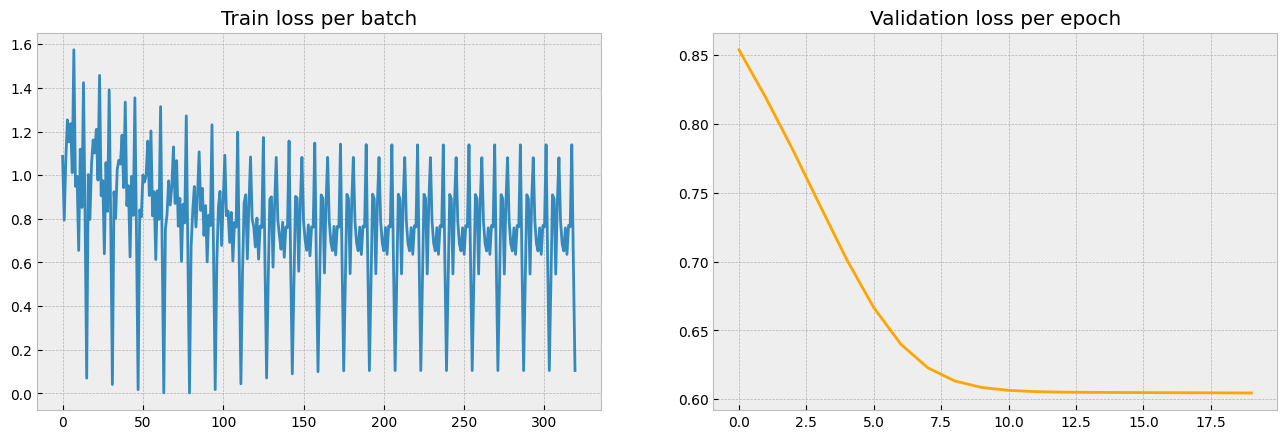

MSE:
Train loss: 0.105
Val loss:   0.605
Test loss:  0.605


In [34]:
metrics = pd.read_csv('./lstm/0/metrics.csv')
train_loss = metrics[['train_loss', 'step', 'epoch']][~np.isnan(metrics['train_loss'])]
val_loss = metrics[['val_loss', 'epoch']][~np.isnan(metrics['val_loss'])]
test_loss = metrics['test_loss'].iloc[-1]

fig, axes = plt.subplots(1, 2, figsize=(16, 5), dpi=100)
axes[0].set_title('Train loss per batch')
axes[0].plot(train_loss['step'], train_loss['train_loss'])
axes[1].set_title('Validation loss per epoch')
axes[1].plot(val_loss['epoch'], val_loss['val_loss'], color='orange')
plt.show(block = True)

print('MSE:')
print(f"Train loss: {train_loss['train_loss'].iloc[-1]:.3f}")
print(f"Val loss:   {val_loss['val_loss'].iloc[-1]:.3f}")
print(f'Test loss:  {test_loss:.3f}')

### Prediction

In [35]:
from torch.autograd import Variable 

X_test_lstm = Variable(torch.tensor(X_AR_test, dtype=torch.float).view(-1, 1, 1))
X_test_lstm.shape

torch.Size([1051, 1, 1])

In [36]:
Y_pred_test_lstm = model(X_test_lstm).detach().numpy()

### Prediction

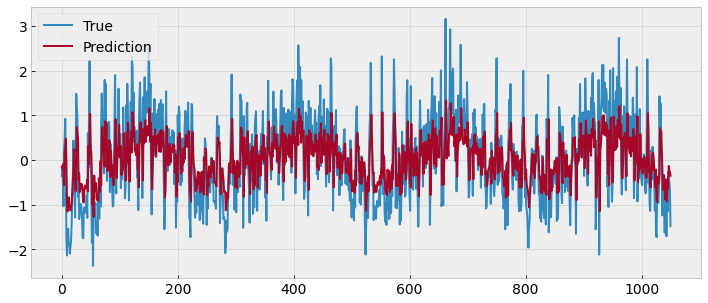

In [37]:
plt.figure(figsize=(12, 5))
plt.plot(Y_AR_test, label='True', alpha=1.)
plt.plot(Y_pred_test_lstm, label='Prediction', alpha=1.)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.show()

In [38]:
print('MSE loss:', mse(Y_AR_test, Y_pred_test_lstm))

MSE loss: 0.6201853481752391


# Task 3

Do the same experiment with LSTM for large k value -- take $k=20$ (in the case of LSTM, this is the length of the sequence):

* train new model;
* compare graphs and MSE losses.

In [40]:
seq_len = 20

p = dict(
    seq_len = seq_len,# your code where
    batch_size = 50, 
    criterion = nn.MSELoss(),
    max_epochs = 20,
    n_features = 1,
    hidden_size = 20,
    num_layers = 1,
    dropout = 0.2,
    learning_rate = 0.001,
)

In [41]:
dm = DataModule(
    seq_len = p['seq_len'],
    batch_size = p['batch_size']
)

In [42]:
model = LSTMRegressor(
    n_features = p['n_features'],
    hidden_size = p['hidden_size'],
    seq_len = p['seq_len'],
    batch_size = p['batch_size'],
    criterion = p['criterion'],
    num_layers = p['num_layers'],
    dropout = p['dropout'],
    learning_rate = p['learning_rate']
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [43]:
seed_everything(1)

csv_logger = CSVLogger('./', name='lstm', version='0'),

trainer = Trainer(
    max_epochs=p['max_epochs'],
    logger=csv_logger,
    gpus=1,
    log_every_n_steps=1,
    progress_bar_refresh_rate=2,
)

Global seed set to 1
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=2)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [44]:
trainer.fit(model, dm)
trainer.test(model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/csv_logs.py:58: UserWarning: Experiment logs directory ./lstm/0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  f"Experiment logs directory {self.log_dir} exists and is not empty."

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 1.8 K 
2 | linear    | Linear  | 21    
--------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.007     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory /content/lstm/0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5632345080375671}
--------------------------------------------------------------------------------


[{'test_loss': 0.5632345080375671}]

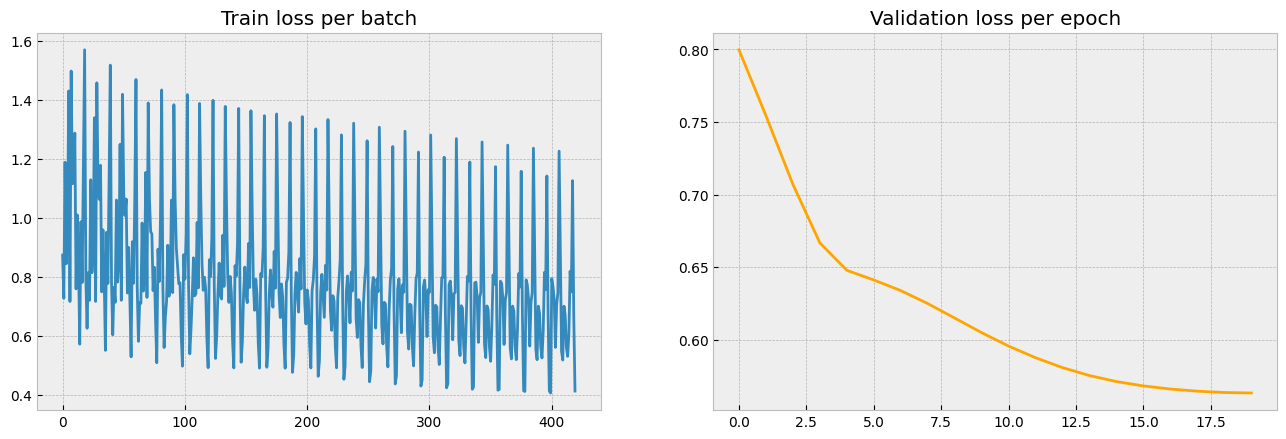

MSE:
Train loss: 0.414
Val loss:   0.563
Test loss:  0.563


In [45]:
metrics = pd.read_csv('./lstm/0/metrics.csv')
train_loss = metrics[['train_loss', 'step', 'epoch']][~np.isnan(metrics['train_loss'])]
val_loss = metrics[['val_loss', 'epoch']][~np.isnan(metrics['val_loss'])]
test_loss = metrics['test_loss'].iloc[-1]

fig, axes = plt.subplots(1, 2, figsize=(16, 5), dpi=100)
axes[0].set_title('Train loss per batch')
axes[0].plot(train_loss['step'], train_loss['train_loss'])
axes[1].set_title('Validation loss per epoch')
axes[1].plot(val_loss['epoch'], val_loss['val_loss'], color='orange')
plt.show(block = True)

print('MSE:')
print(f"Train loss: {train_loss['train_loss'].iloc[-1]:.3f}")
print(f"Val loss:   {val_loss['val_loss'].iloc[-1]:.3f}")
print(f'Test loss:  {test_loss:.3f}')

### Prediction

In [60]:
# X_AR_test_new_k_lstm = Variable(torch.tensor(X_AR_test, dtype=torch.float).resize_(1022, 30, 1)) # your code here
# X_AR_test_new_k_lstm.shape
# assert X_AR_test_new_k_lstm.shape == torch.Size([1022, 30, 1])
# Variant vishe toge rabotaet
X_AR_test_new_k_lstm = Variable(torch.tensor(X_AR_test_new_k, dtype=torch.float)[:, :, None]) 
assert X_AR_test_new_k_lstm.shape == torch.Size([1022, 30, 1])

In [61]:
Y_pred_test_new_k_lstm = model(X_AR_test_new_k_lstm).detach().numpy() # your code here

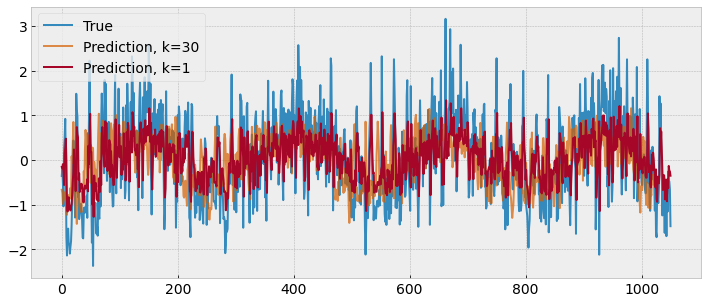

In [62]:
for i in range(Y_AR_test.shape[1]):
    plt.figure(figsize=(12, 5))
    plt.plot(Y_AR_test, label='True', alpha=1.)
    plt.plot(Y_pred_test_new_k_lstm, label=f'Prediction, k={new_k}', alpha=.7, color='C4')
    plt.plot(Y_pred_test_lstm, label='Prediction, k=1', alpha=1.)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', fontsize=14)
    plt.grid(b=1)
    plt.show()

In [63]:
print('MSE loss k=1:', mse(Y_pred_test_lstm, Y_AR_test))
print(f'MSE loss k={seq_len}:', mse(Y_pred_test_new_k_lstm, Y_AR_test_new_k))

MSE loss k=1: 0.6201853481752391
MSE loss k=20: 0.5919905933220804


# Conclusion

In this notebook, we have learned to use predict a rather toy-like time series using linear models and recurrent neural networks.